# Data Loading

In [1]:
import pandas as pd

INPUT_DIR = '../data/raw/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/'

global_death_covid = pd.read_csv(f"{INPUT_DIR}/time_series_covid19_deaths_global.csv")
global_death_covid.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/19/22,3/20/22,3/21/22,3/22/22,3/23/22,3/24/22,3/25/22,3/26/22,3/27/22,3/28/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7652,7654,7654,7656,7657,7657,7657,7657,7662,7663
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3487,3487,3487,3489,3489,3489,3490,3491,3491,3491
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6871,6871,6872,6873,6873,6873,6873,6873,6873,6873
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,153,153,153,153,153,155,153,153,153,153
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1900,1900,1900,1900,1900,1900,1900,1900,1900,1900


# Scripts
## First script to convert one entry of a dataset to the correct format

In [2]:
def convert_df_to_time_series(
    dataset: pd.DataFrame, time_series_name: str, differential=True
) -> pd.DataFrame:
    """Convert a dataframe of time records coming from one country (and one province attached to it) to a plotable time series
    Args:
        dataset (pd.DataFrame): input dataset
        time_series_name (str): name of the time series
        differential (bool, optional): differential data to get by day. Defaults to True.

    Returns:
        _type_: dataframe ready to be plotted
    """

    dataset_data_time_serie = dataset.drop(
        ["Province/State", "Country/Region", "Lat", "Long"], axis=1
    ).T
    dataset_data_time_serie.columns = [time_series_name]
    if differential:
        dataset_data_time_serie = dataset_data_time_serie.diff(axis=0)

        # rolling mean (7-days average)
        dataset_data_time_serie[
            f"{time_series_name}_7-days_average"
        ] = dataset_data_time_serie.rolling(window=7).mean()

    dataset_data_time_serie.index = pd.to_datetime(dataset_data_time_serie.index)
    return dataset_data_time_serie

In [3]:
input_dataset = global_death_covid[global_death_covid["Country/Region"] == "Afghanistan"]

dataset_processed: pd.DataFrame = convert_df_to_time_series(input_dataset,"Deaths")
dataset_processed

,Deaths,Deaths_7-days_average
2020-01-22,NaN,NaN
2020-01-23,0.0,NaN
2020-01-24,0.0,NaN
2020-01-25,0.0,NaN
2020-01-26,0.0,NaN
...,...,...
2022-03-24,0.0,0.857143
2022-03-25,0.0,0.857143
2022-03-26,0.0,0.714286
2022-03-27,5.0,1.142857


## Script to convert csv to dataframe with time series format (normal + 7-days rolling avg)

In [4]:
from typing import List
from tqdm import tqdm

def convert_dataset_to_time_series(input_filepath: str) -> pd.DataFrame:

    dataset: pd.DataFrame = pd.read_csv(input_filepath)
    tmp_df: List[pd.DataFrame] = []

    with tqdm(total=len(dataset), desc="Converting dataset entry to time series format (normal + 7-days rolling avg)") as pbar:

        for i in range(len(dataset)):

            time_serie_name: str = dataset.iloc[i]['Country/Region'] if pd.isna(dataset.iloc[i]['Province/State']) else dataset.iloc[i]['Province/State']
            pbar.set_description(f"Converting dataset entry to time series format (normal + 7-days rolling avg), processing {time_serie_name}")

            tmp_df.append(convert_df_to_time_series(dataset.iloc[i].to_frame().T, time_serie_name))

            pbar.update(1)

    process_dataset: pd.DataFrame = pd.concat(tmp_df, axis=1)
    return process_dataset

processed_dataset: pd.DataFrame = convert_dataset_to_time_series(f"{INPUT_DIR}/time_series_covid19_deaths_global.csv")

Converting dataset entry to time series format (normal + 7-days rolling avg), processing Zimbabwe: 100%|██████████| 284/284 [00:18<00:00, 15.35it/s]                                    


In [5]:
processed_dataset.tail()

,Afghanistan,Afghanistan_7-days_average,Albania,Albania_7-days_average,Algeria,Algeria_7-days_average,Andorra,Andorra_7-days_average,Angola,Angola_7-days_average,...,West Bank and Gaza,West Bank and Gaza_7-days_average,Winter Olympics 2022,Winter Olympics 2022_7-days_average,Yemen,Yemen_7-days_average,Zambia,Zambia_7-days_average,Zimbabwe,Zimbabwe_7-days_average
2022-03-24,0,0.857143,0,0.285714,0,0.428571,2,0.285714,0,0.0,...,8,3.0,0,0.0,0,0.285714,1,0.428571,0,2.000000
2022-03-25,0,0.857143,1,0.428571,0,0.285714,-2,0.000000,0,0.0,...,0,3.0,0,0.0,0,0.285714,1,0.571429,4,2.285714
2022-03-26,0,0.714286,1,0.571429,0,0.285714,0,0.000000,0,0.0,...,0,3.0,0,0.0,0,0.285714,0,0.571429,0,1.428571
2022-03-27,5,1.142857,0,0.571429,0,0.285714,0,0.000000,0,0.0,...,0,3.0,0,0.0,0,0.285714,0,0.571429,2,1.714286
2022-03-28,1,1.285714,0,0.571429,0,0.142857,0,0.000000,0,0.0,...,6,2.0,0,0.0,0,0.000000,0,0.428571,0,1.285714


<AxesSubplot:>

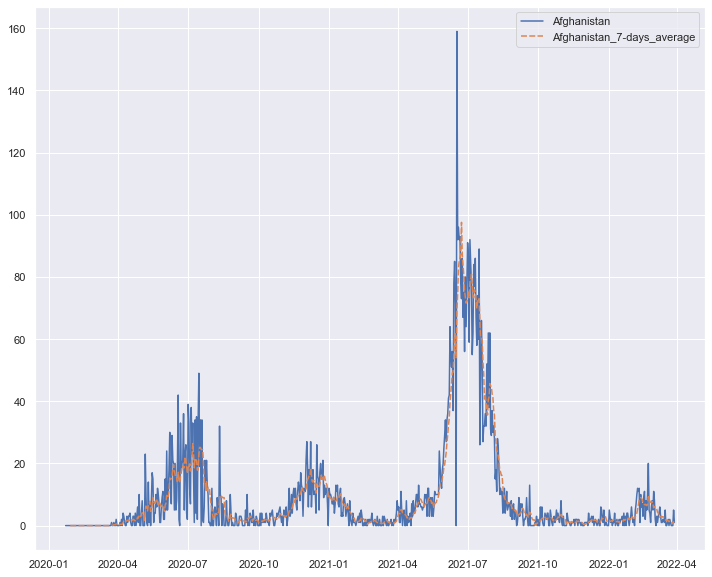

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,10)})
sns.set_theme()

sns.lineplot(data=[processed_dataset["Afghanistan"], processed_dataset["Afghanistan_7-days_average"]])